# Statistical Test for the CLIPScore

In this notebook the CLIPScore will be computed and compared on human and non-human annotated captions. The goal is to understand if the CLIPScore is able to catch the difference in the annotation process that took to the production of the captions. If it is able to do that, than the score is a valid metric to understand how much the captions fit the artworks.

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from transformers import CLIPModel, CLIPProcessor
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from joblib import load

/home/nico/Thesis/neural-artwork-caption-generator/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PROJECT_DIR = Path(os.getcwd()).resolve().parent
DATA_DIR = PROJECT_DIR / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
INTERIM_DATA_DIR = DATA_DIR / "interim"
IMAGES_DIR = RAW_DATA_DIR / "images"

In [3]:
df_captions = pd.read_csv(RAW_DATA_DIR / "artgraph_captions.csv")
df_captions

image   
0                         leonardo-da-vinci_mona-lisa.jpg  \
1       henri-de-toulouse-lautrec_in-bed-the-kiss-1892...   
2           sandro-botticelli_the-birth-of-venus-1485.jpg   
3                 claude-monet_madame-monet-and-child.jpg   
4                          gustav-klimt_the-kiss-1908.jpg   
...                                                   ...   
116470                alexander-ivanov_via-appia-1845.jpg   
116471   alexander-ivanov_portrait-of-vittoria-marini.jpg   
116472                   alexander-ivanov_olive-trees.jpg   
116473             alexander-ivanov_annunciation-1824.jpg   
116474  alexander-ivanov_on-the-shore-of-the-bay-of-na...   

                                                     name   
0                            Mona Lisa; Leonardo da Vinci  \
1             In Bed, The Kiss; Henri de Toulouse-Lautrec   
2                   The Birth of Venus; Sandro Botticelli   
3       Camille Monet and a Child in the Artist’s Gard...   
4                                  The Kiss; Gustav Klimt   
...                                                   ...   
116470                        Via Appia; Alexander Ivanov   
116471      Portrait of Vittoria Marini; Alexander Ivanov   
116472                      Olive trees; Alexander Ivanov   
116473                     Annunciation; Alexander Ivanov   
116474  On the shore of the Bay of Naples; Alexander I...   

                                                  caption human  
0       The artwork depicts a woman with a mysterious ...     y  
1       The artwork depicts a couple in bed sharing a ...     y  
2       The artwork depicts a naked woman standing on ...     y  
3       The artwork depicts a woman and child in a gar...     y  
4       The artwork depicts a couple embracing, surrou...     y  
...                                                   ...   ...  
116470  The artwork depicts a scene from the Via Appia...     n  
116471  The artwork depicts a young woman with curly h...     n  
116472  The artwork depicts a group of olive trees on ...     n  
116473  The artwork depicts an angel with outstretched...     n  
116474  The artwork depicts several figures on a beach...     n  

[116475 rows x 4 columns]

For the test, the captions will be divided into human and not-human annotated captions.

In [4]:
df_human = df_captions[df_captions["human"] == "y"][["image", "caption"]]
df_not_human = df_captions[df_captions["human"] == "n"][["image", "caption"]]

Compare sets of captions of the same size, by excluding the non-human captions.

In [5]:
df_not_human = df_not_human.sample(len(df_human), random_state=42)
df_not_human

image   
99973   louise-elisabeth-vigee-le-brun_self-portrait-w...  \
38014                   thomas-dewing_a-musician-1877.jpg   
32308   ferdinand-hodler_farewell-participating-female...   
88919       william-h-johnson_still-life-flowers-1938.jpg   
60925            charles-turner_william-wallis-1810-1.jpg   
...                                                   ...   
100281  vasily-surikov_krasnoyarsk-kachinskaya-street-...   
63816   benjamin-west_choice-of-hercules-between-virtu...   
41754     thomas-eakins_portrait-of-dr-horatio-c-wood.jpg   
9436    pierre-auguste-renoir_young-girl-slipping-on-h...   
103604  marjorie-acker-phillips_impressionist-landscap...   

                                                  caption  
99973   The artwork depicts Mrs Vigee-Lebrun and her d...  
38014   The artwork depicts a woman playing a stringed...  
32308   The artwork depicts a female figure saying far...  
88919   The artwork depicts a vase with several colorf...  
60925   The artwork depicts a portrait of a man with s...  
...                                                   ...  
100281  The artwork depicts Kachinskaya street in Kras...  
63816   The artwork depicts the choice of Hercules bet...  
41754   The artwork depicts Dr. Horatio C Wood, who is...  
9436    The artwork depicts a young girl seated on a b...  
103604  The artwork depicts a serene and colorful impr...  

[500 rows x 2 columns]

In [6]:
embeddings_dict = load(INTERIM_DATA_DIR / "clip" / "dataset_embeddings.joblib")

In [7]:
h_img_embeddings = []
nh_img_embeddings = []
human_embeddings = []
not_human_embeddings = []

for k, v in embeddings_dict.items():
    if k in df_human["image"].values:
        h_img_embeddings.append(v["img_embedding"])
        human_embeddings.append(v["caption_embedding"])
    elif k in df_not_human["image"].values:
        nh_img_embeddings.append(v["img_embedding"])
        not_human_embeddings.append(v["caption_embedding"])

h_img_embeddings = np.array(h_img_embeddings)
nh_img_embeddings = np.array(nh_img_embeddings)
human_embeddings = np.array(human_embeddings)
not_human_embeddings = np.array(not_human_embeddings)

The prefix "The artwork depicts" will be removed from the captions.

Prepare the captions for the CLIP model.

Encode the captions to create CLIP embeddings.

The precomputed image embeddings are stored in a file, in alphabetical order of the content of the images of the dir.

Find alphabetical indices.

In [8]:
h_scores = np.diagonal(cosine_similarity(h_img_embeddings, human_embeddings))
nh_scores = np.diagonal(cosine_similarity(nh_img_embeddings, not_human_embeddings))

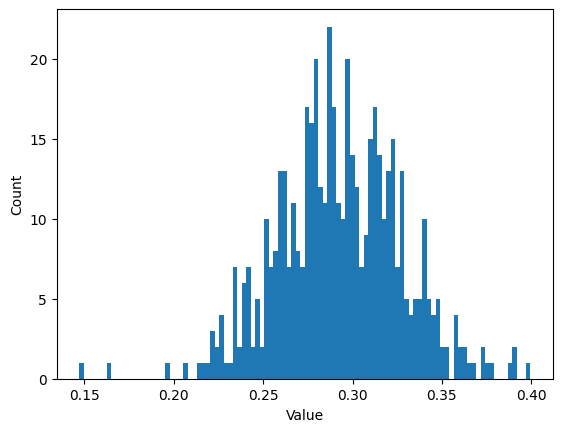

In [9]:
plt.hist(h_scores, bins=100)

# Add labels and a title
plt.xlabel('Value')
plt.ylabel('Count')

# Display the plot
plt.savefig("clipscore_human.png", dpi=300)
plt.show()

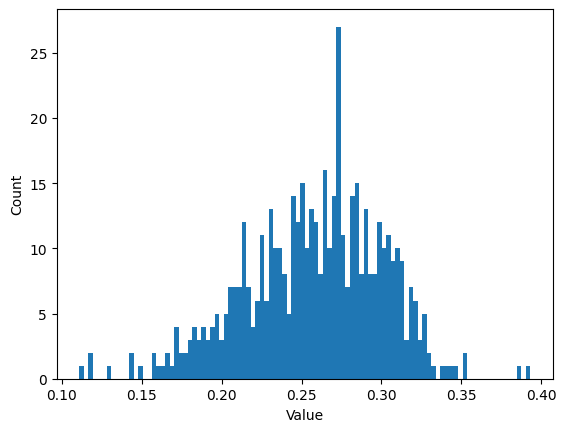

In [10]:
plt.hist(nh_scores, bins=100)

# Add labels and a title
plt.xlabel('Value')
plt.ylabel('Count')

# Display the plot
plt.savefig("clipscore_not_human.png", dpi=300)
plt.show()

In [11]:
np.var(nh_scores, ddof=1), np.mean(nh_scores), np.std(nh_scores, ddof=1)

(0.0018806744147962743, 0.25762837664914956, 0.04336674318871864)

In [12]:
np.var(h_scores, ddof=1), np.mean(h_scores), np.std(h_scores, ddof=1)

(0.001205103792192639, 0.29268641270384405, 0.034714604883141605)

In [13]:
#define F-test function
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p

#perform F-test
f_test(nh_scores, h_scores)

(1.5605912345313104, 3.7444018519128264e-07)

In [14]:
scipy.stats.ttest_ind(h_scores, nh_scores, equal_var=False)

Ttest_indResult(statistic=14.112054068273148, pvalue=3.3296763513182695e-41)

Show the highest and lowest scores.

In [15]:
# get indices of worst and top 3 scores
h_worst = np.argsort(h_scores)[:3]
h_best = np.argsort(h_scores)[-3:]
nh_worst = np.argsort(nh_scores)[:3]
nh_best = np.argsort(nh_scores)[-3:]

In [16]:
df_human

image   
0                      leonardo-da-vinci_mona-lisa.jpg  \
1    henri-de-toulouse-lautrec_in-bed-the-kiss-1892...   
2        sandro-botticelli_the-birth-of-venus-1485.jpg   
3              claude-monet_madame-monet-and-child.jpg   
4                       gustav-klimt_the-kiss-1908.jpg   
..                                                 ...   
495           juan-gris_harlequin-with-guitar-1919.jpg   
496                            tintoretto_paradise.jpg   
497     jean-honore-fragonard_the-stolen-kiss-1788.jpg   
498  frederic-leighton_the-fisherman-and-the-syren-...   
499        annibale-carracci_the-flight-into-egypt.jpg   

                                               caption  
0    The artwork depicts a woman with a mysterious ...  
1    The artwork depicts a couple in bed sharing a ...  
2    The artwork depicts a naked woman standing on ...  
3    The artwork depicts a woman and child in a gar...  
4    The artwork depicts a couple embracing, surrou...  
..                                                 ...  
495  The artwork depicts a Cubist-style Harlequin f...  
496  The artwork depicts a sprawling, heavenly scen...  
497  The artwork depicts a romantic, clandestine mo...  
498  The artwork depicts a tender encounter between...  
499  The artwork depicts the Holy Family's flight i...  

[500 rows x 2 columns]

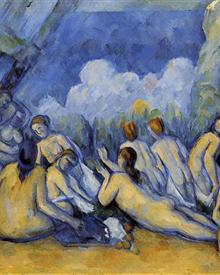

The artwork depicts several nude women bathing in a river, against a gradient background.


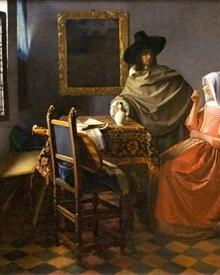

The artwork depicts a young woman standing behind a table. She holds a glass of wine and drinks the wine under the stare of a man with a black hat. The room is dark and richly decorated.


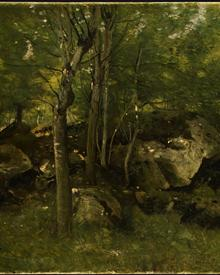

The artwork depicts a peaceful forest scene in Fontainebleau, with trees, and dappled sunlight.


In [17]:
for i, row in df_human.iloc[h_worst].iterrows():
    display(Image.open(IMAGES_DIR / row["image"]))
    print(row["caption"])

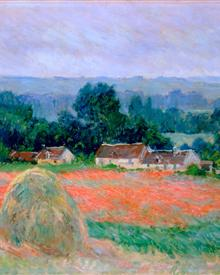

The artwork depicts a field with a haystack and trees in the background, with a blue sky and white clouds above.


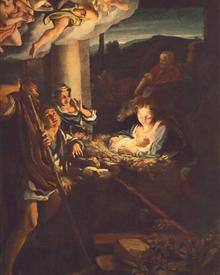

The artwork depicts the shepherds adoring the baby Jesus in a stable.


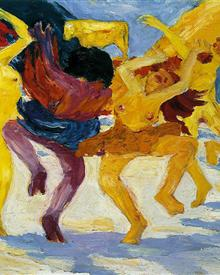

The artwork depicts a group of people dancing around a golden calf, with a landscape in the background.


In [18]:
for i, row in df_human.iloc[h_best].iterrows():
    display(Image.open(IMAGES_DIR / row["image"]))
    print(row["caption"])

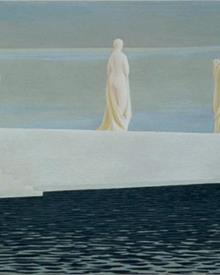

The artwork depicts four figures on a wharf, possibly waiting for a boat.
[0.11100511 0.11740063 0.11823536]


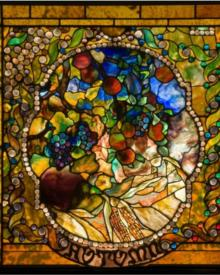

The artwork depicts a panel with various colorful and textured glass pieces arranged in a landscape pattern, showing an autumnal scene with trees, leaves, and birds.
[0.11100511 0.11740063 0.11823536]


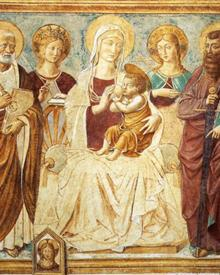

The artwork depicts Maria lactans (detail) in the Tabernacle of the Madonna delle Tosse with the Virgin Mary breastfeeding the infant Jesus.
[0.11100511 0.11740063 0.11823536]


In [19]:
for i, row in df_not_human.iloc[nh_worst].iterrows():
    display(Image.open(IMAGES_DIR / row["image"]))
    print(row["caption"])
    print(nh_scores[nh_worst])

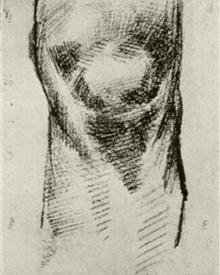

The artwork depicts a sketch of a knee.
[0.3524618  0.38673405 0.39320095]


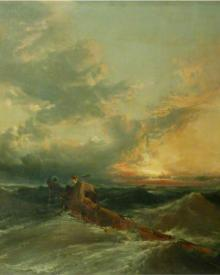

The artwork depicts a railway signal tower, with intricate details and patterns.
[0.3524618  0.38673405 0.39320095]


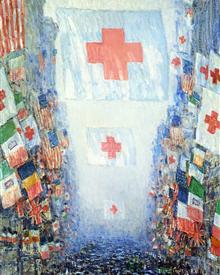

The artwork depicts a festive parade with people and colorful flags, with a cloudy sky and buildings in the background.
[0.3524618  0.38673405 0.39320095]


In [20]:
for i, row in df_not_human.iloc[nh_best].iterrows():
    display(Image.open(IMAGES_DIR / row["image"]))
    print(row["caption"])
    print(nh_scores[nh_best])

In [21]:
# Get the sorted indices
sorted_indices = np.argsort(nh_scores)

# Sort the array
sorted_arr = nh_scores[sorted_indices]

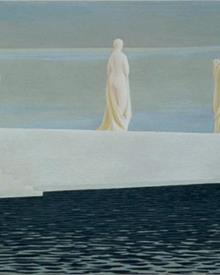

The artwork depicts four figures on a wharf, possibly waiting for a boat.
0.11100510508226108


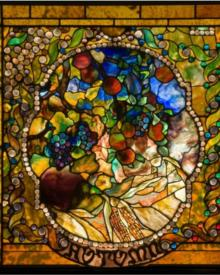

The artwork depicts a panel with various colorful and textured glass pieces arranged in a landscape pattern, showing an autumnal scene with trees, leaves, and birds.
0.11740062974852544


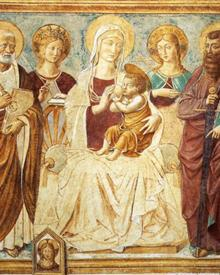

The artwork depicts Maria lactans (detail) in the Tabernacle of the Madonna delle Tosse with the Virgin Mary breastfeeding the infant Jesus.
0.11823536352966194


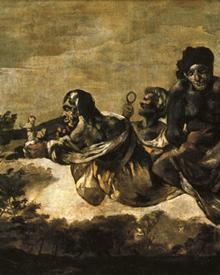

The artwork depicts three women identified as the Fates. One of them is cutting a thread with scissors.
0.12942354337339815


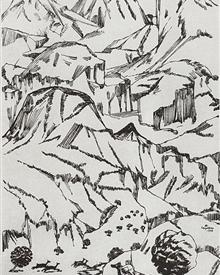

The artwork depicts majestic mountains.
0.14373110495517918


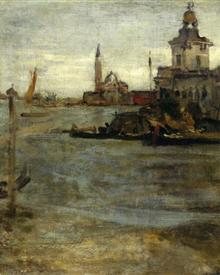

The artwork depicts a canal in Venice, with boats and buildings on both sides of the water.
0.14405691053121292


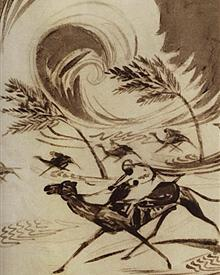

The artwork depicts an illustration to the poem "Abu Lala Mahari" featuring a man on horseback riding through a mountainous landscape.
0.14969900383329166


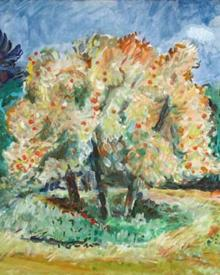

The artwork depicts apple trees and clouds in the late afternoon.
0.15770276782859732


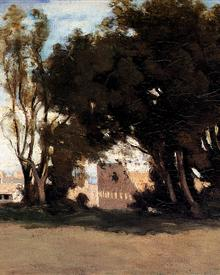

The artwork depicts a view of the Coliseum in Rome from the Farnese Gardens, with trees, ruins, and a distant view of the city.
0.1587617398925655


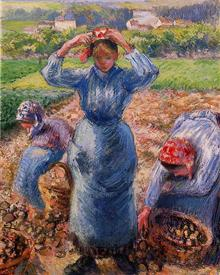

The artwork depicts peasants working in a field, harvesting potatoes in baskets and bags.
0.1599627185743207


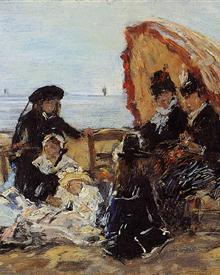

The artwork depicts a woman sitting on a beach with a parasol, looking out at the ocean, with buildings and people visible in the background.
0.16454171302583803


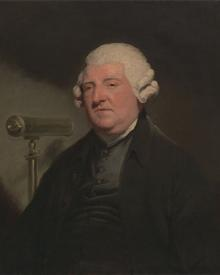

The artwork depicts a portrait of a man in a dark coat, holding a telescope.
0.16521169261953825


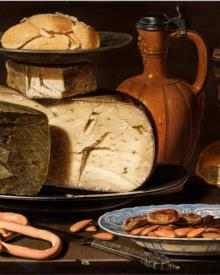

The artwork depicts a still life scene with an arrangement of cheeses, almonds, and pretzels on a table.
0.16652560911643577


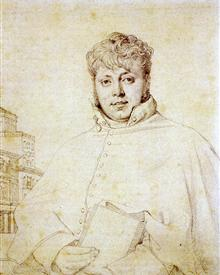

The artwork depicts Auguste-Jean-Marie Guénepin.
0.16829638419531595


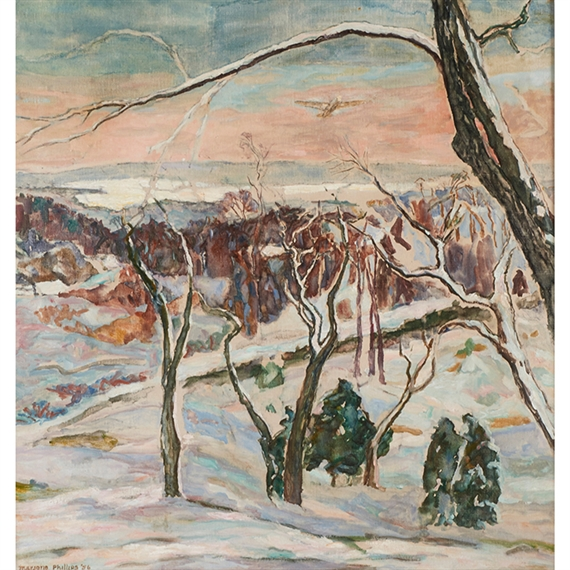

The artwork depicts a serene and colorful impressionist landscape.
0.1714216996444629


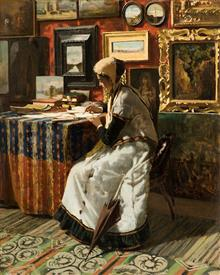

The artwork depicts a person anxiously waiting for a letter.
0.17183930296601074


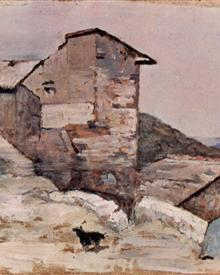

The artwork depicts a rustic farmstead with a group of figures and animals, set against a hilly landscape with cloudy skies.
0.17242807058583987


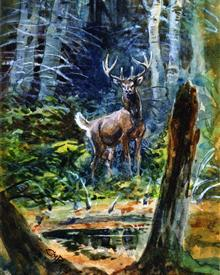

The artwork depicts a serene scene of a deer grazing in a peaceful dell surrounded by trees and mountains.
0.17283044743046894


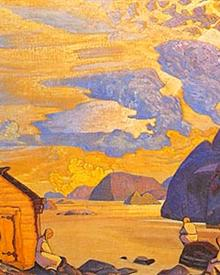

The artwork depicts someone waiting.
0.17574962875003194


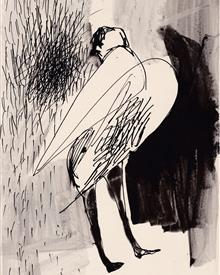

The artwork depicts a series of colorful geometric shapes on a dark background.
0.17584929813676886


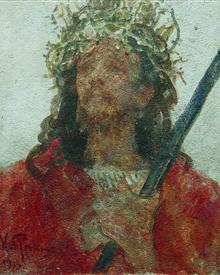

The artwork depicts Jesus in a crown of thorns, with blood trickling down his forehead.
0.17743598336366667


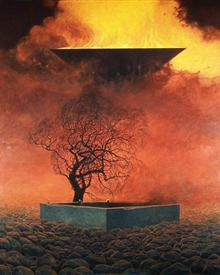

The artwork depicts a macabre, nightmarish scene with a large, ominous structure and figures in agony and distress, surrounded by a chaotic, fiery background and a skeletal structure in the foreground.
0.17847817275346242


In [22]:
for i, score in enumerate(sorted_arr):
    display(Image.open(IMAGES_DIR / df_not_human.iloc[sorted_indices[i]]["image"]))
    print(df_not_human.iloc[sorted_indices[i]]["caption"])
    print(score)
    if i > 20:
        break

In [23]:
filenames_lookup = {v: i for i, v in enumerate(filenames)}

NameError: name 'filenames' is not defined

In [ ]:
df_captions["filename_index"] = df_captions["image"].apply(lambda x: filenames_lookup[x])

In [ ]:
all_captions = df_captions["caption"].tolist()
all_captions = [remove_prefix(c) for c in all_captions]
all_captions

['a woman with a mysterious smile, sitting in front of a landscape.',
 'a couple in bed sharing a passionate kiss.',
 'a naked woman standing on a shell on the sea, surrounded by figures.',
 'a woman and child in a garden, surrounded by trees and flowers.',
 'a couple embracing, surrounded by a golden mosaic pattern.',
 'a sunrise over a harbor with boats and reflections on the water.',
 'a still life with a basket of apples and a bottle on a table with a cloth.',
 'two nude women and two clothed men having a picnic in a forest.',
 'a surreal landscape with strange creatures, plants, and people.',
 'a woman in a golden dress surrounded by patterns and shapes.',
 'a tree in a field with a red background and black lines.',
 "a woman's face in a stylized and elongated form.",
 'abstract shapes and lines in bright colors.',
 'three shapes in yellow, red, and blue floating on a white background.',
 'three dancers practicing in a brightly lit exercise hall.',
 'a girl sitting on a sofa, hold

In [ ]:
caption_embeddings = np.empty((1, 512))

for i in tqdm(range(0, len(all_captions), 8)):
    batch_captions = all_captions[i : min(i+8, len(all_captions))]
    # keep only the first 40 words
    batch_captions = [" ".join(c.split()[:40]) for c in batch_captions]

    inputs = processor(text=batch_captions, images=None, return_tensors="pt", padding=True)

    try:
        features = model.get_text_features(**inputs)
    except e:
        print(e)
        print(batch_captions)
        continue

    caption_embeddings = np.concatenate(
        (caption_embeddings, features.detach().numpy()), axis=0
    )

caption_embeddings = caption_embeddings[1:,:]

 22%|██▏       | 3247/14560 [12:41<44:11,  4.27it/s]  


NameError: name 'e' is not defined